In [ ]:
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense,Conv2D, Flatten, MaxPool2D, Dropout

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_path = '/content/drive/MyDrive/Data/train'
val_path = '/content/drive/MyDrive/Data/valid'
test_path = '/content/drive/MyDrive/Data/test'

In [ ]:
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
        # Counting the Number of Files in the Folder
        num_of_image[folder] = len(os.listdir(os.path.join(path, folder)));
    return num_of_image;

train_set = GetDatasetSize(train_path)
val_set = GetDatasetSize(val_path)
test_set = GetDatasetSize(test_path)
print(train_set,"\n\n",val_set,"\n\n",test_set)

{'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 115, 'normal': 148, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 155, 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 195} 

 {'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 15, 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 23, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 21, 'normal': 13} 

 {'squamous.cell.carcinoma': 90, 'normal': 54, 'large.cell.carcinoma': 51, 'adenocarcinoma': 120}


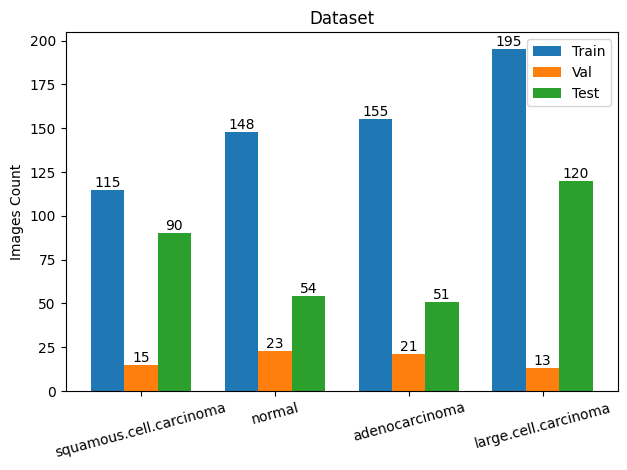

In [ ]:
labels = ['squamous.cell.carcinoma', 'normal', 'adenocarcinoma', 'large.cell.carcinoma']
train_list = list(train_set.values())
val_list = list(val_set.values())
test_list = list(test_set.values())

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, train_list, width, label='Train')
rects2 = ax.bar(x, val_list, width, label='Val')
rects3 = ax.bar(x + width, test_list, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Images Count')
ax.set_title('Dataset')
ax.set_xticks(x, labels)
plt.xticks(rotation=15)
ax.legend()

ax.bar_label(rects1)
ax.bar_label(rects2)
ax.bar_label(rects3)

fig.tight_layout()

plt.show()

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                  horizontal_flip = True,
                                  fill_mode = 'nearest',
                                  zoom_range=0.2,
                                  shear_range = 0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  rotation_range=0.4)

train_data = train_datagen.flow_from_directory(train_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.


In [ ]:
train_data.class_indices

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [ ]:
val_datagen = ImageDataGenerator(rescale = 1.0/255.0)
val_data = val_datagen.flow_from_directory(val_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

Found 72 images belonging to 4 classes.


In [ ]:
val_data.class_indices

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1.0/255.0)
test_data = test_datagen.flow_from_directory(test_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

Found 315 images belonging to 4 classes.


In [ ]:
test_data.class_indices

{'adenocarcinoma': 0,
 'large.cell.carcinoma': 1,
 'normal': 2,
 'squamous.cell.carcinoma': 3}

# VGG-16

In [ ]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(350,350,3)
)

In [ ]:
NUM_CLASSES = 4

vgg_model = Sequential()
vgg_model.add(base_model)
vgg_model.add(layers.Flatten())
vgg_model.add(layers.Dropout(0.25))
vgg_model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

vgg_model.layers[0].trainable = False

vgg_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

vgg_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 10, 10, 512)       14714688  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dropout_1 (Dropout)         (None, 51200)             0         
                                                                 
 dense_1 (Dense)             (None, 4)                 204804    
                                                                 
Total params: 14919492 (56.91 MB)
Trainable params: 204804 (800.02 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
# Adding Model check point Callback

mc = ModelCheckpoint(
    filepath="./ct_vgg_best_model.hdf5",
    monitor= 'val_accuracy',
    verbose= 1,
    save_best_only= True,
    mode = 'auto'
    );
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

call_back = [mc,early_stopping];

In [ ]:
# Define hyperparameters for tuning
learning_rates = [0.001, 0.0001]
batch_sizes = [16, 32, 64]

best_accuracy = 0
best_hyperparameters = {}

# Hyperparameter tuning loop
for lr in learning_rates:
    for batch_size in batch_sizes:

         # Fitting the Model
         vgg = vgg_model.fit(
             train_data,
            steps_per_epoch = train_data.samples//train_data.batch_size,
            epochs = 12,
            validation_data = val_data,
            validation_steps = val_data.samples//val_data.batch_size,
            callbacks = call_back
             )
         _, accuracy = model.evaluate(test_data)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_hyperparameters = {'learning_rate': lr, 'batch_size': batch_size}

Epoch 1/12
122/122 [==============================] - ETA: 0s - loss: 2.4797 - accuracy: 0.4490
Epoch 1: val_accuracy improved from -inf to 0.60000, saving model to ./ct_vgg_best_model.hdf5
122/122 [==============================] - 993s 8s/step - loss: 2.4797 - accuracy: 0.4490 - val_loss: 1.4822 - val_accuracy: 0.6000
Epoch 2/12
122/122 [==============================] - ETA: 0s - loss: 2.1345 - accuracy: 0.5230
Epoch 2: val_accuracy did not improve from 0.60000
122/122 [==============================] - 1029s 8s/step - loss: 2.1345 - accuracy: 0.5230 - val_loss: 1.9876 - val_accuracy: 0.5000
Epoch 3/12
122/122 [==============================] - ETA: 0s - loss: 1.8928 - accuracy: 0.6053
Epoch 3: val_accuracy did not improve from 0.60000
122/122 [==============================] - 1027s 8s/step - loss: 1.8928 - accuracy: 0.6053 - val_loss: 1.0005 - val_accuracy: 0.5857
Epoch 4/12
122/122 [==============================] - ETA: 0s - loss: 1.4845 - accuracy: 0.6349
Epoch 4: val_accuracy 

In [ ]:
# Loading the Best Fit Model
model = load_model("./ct_vgg_best_model.hdf5")

In [ ]:
# Checking the Accuracy of the Model
accuracy_vgg = model.evaluate_generator(generator= test_data)[1]
print(f"The accuracy of the model is = {accuracy_vgg*100} %")

The accuracy of the model is = 80.63492178916931 %


In [ ]:
vgg.history.keys()

In [ ]:
# Plot model performance
acc = vgg.history['accuracy']
val_acc = vgg.history['val_accuracy']
loss = vgg.history['loss']
val_loss = vgg.history['val_loss']
epochs_range = range(1, len(vgg.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
# Extract features using VGG16 model
train_features_vgg = base_model.predict(train_data)
val_features_vgg = base_model.predict(val_data)
test_features_vgg = base_model.predict(test_data)

63/63 [==============================] - 447s 7s/step


In [ ]:
# Flatten the features
train_features_flat_vgg = train_features_vgg.reshape(train_features_vgg.shape[0], -1)
val_features_flat_vgg = val_features_vgg.reshape(val_features_vgg.shape[0], -1)
test_features_flat_vgg = test_features_vgg.reshape(test_features_vgg.shape[0], -1)

In [ ]:
# Define and train Random Forest Classifier with VGG16 features
rf_classifier_vgg = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_vgg.fit(train_features_flat_vgg, train_data.classes)

# Evaluate Random Forest Classifier
rf_train_accuracy_vgg = rf_classifier_vgg.score(train_features_flat_vgg, train_data.classes)
rf_val_accuracy_vgg = rf_classifier_vgg.score(val_features_flat_vgg, val_data.classes)
rf_test_accuracy_vgg = rf_classifier_vgg.score(test_features_flat_vgg, test_data.classes)

print("Random Forest Classifier with VGG16 features:")
print(f"Train Accuracy: {rf_train_accuracy_vgg*100:.2f}%")
print(f"Validation Accuracy: {rf_val_accuracy_vgg*100:.2f}%")
print(f"Test Accuracy: {rf_test_accuracy_vgg*100:.2f}%")

Random Forest Classifier with VGG16 features:
Train Accuracy: 100.00%
Validation Accuracy: 26.39%
Test Accuracy: 33.33%


In [ ]:
# Define and train Support Vector Machine (SVM) with VGG16 features
svm_classifier_vgg = SVC(kernel='linear', C=1.0, random_state=42)
svm_classifier_vgg.fit(train_features_flat_vgg, train_data.classes)

# Evaluate SVM Classifier
svm_train_accuracy_vgg = svm_classifier_vgg.score(train_features_flat_vgg, train_data.classes)
svm_val_accuracy_vgg = svm_classifier_vgg.score(val_features_flat_vgg, val_data.classes)
svm_test_accuracy_vgg = svm_classifier_vgg.score(test_features_flat_vgg, test_data.classes)

print("\nSupport Vector Machine (SVM) with VGG16 features:")
print(f"Train Accuracy: {svm_train_accuracy_vgg*100:.2f}%")
print(f"Validation Accuracy: {svm_val_accuracy_vgg*100:.2f}%")
print(f"Test Accuracy: {svm_test_accuracy_vgg*100:.2f}%")


Support Vector Machine (SVM) with VGG16 features:
Train Accuracy: 100.00%
Validation Accuracy: 25.00%
Test Accuracy: 25.40%


In [ ]:
# Define and train Logistic Regression with VGG16 features
logistic_classifier_vgg = LogisticRegression(max_iter=1000, random_state=42)
logistic_classifier_vgg.fit(train_features_flat_vgg, train_data.classes)

# Evaluate Logistic Regression Classifier
logistic_train_accuracy_vgg = logistic_classifier_vgg.score(train_features_flat_vgg, train_data.classes)
logistic_val_accuracy_vgg = logistic_classifier_vgg.score(val_features_flat_vgg, val_data.classes)
logistic_test_accuracy_vgg = logistic_classifier_vgg.score(test_features_flat_vgg, test_data.classes)

print("\nLogistic Regression with VGG16 features:")
print(f"Train Accuracy: {logistic_train_accuracy_vgg*100:.2f}%")
print(f"Validation Accuracy: {logistic_val_accuracy_vgg*100:.2f}%")
print(f"Test Accuracy: {logistic_test_accuracy_vgg*100:.2f}%")

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Feature scaling
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features_flat_vgg)
val_features_scaled = scaler.transform(val_features_flat_vgg)
test_features_scaled = scaler.transform(test_features_flat_vgg)

# Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid_search = GridSearchCV(rf_classifier, param_grid=rf_param_grid, cv=3, verbose=1, n_jobs=-1)
rf_grid_search.fit(train_features_scaled, train_data.classes)

# Best Random Forest Classifier
best_rf_classifier = rf_grid_search.best_estimator_
best_rf_val_accuracy = best_rf_classifier.score(val_features_scaled, val_data.classes)
best_rf_test_accuracy = best_rf_classifier.score(test_features_scaled, test_data.classes)

print("\nBest Random Forest Classifier:")
print(f"Validation Accuracy: {best_rf_val_accuracy*100:.2f}%")
print(f"Test Accuracy: {best_rf_test_accuracy*100:.2f}%")
print("Best Parameters:", rf_grid_search.best_params_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits

Best Random Forest Classifier:
Validation Accuracy: 33.33%
Test Accuracy: 33.33%
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
def chestScanPrediction(path, _model):
    classes_dir = ["Adenocarcinoma","Large cell carcinoma","Normal","Squamous cell carcinoma"]
    img = image.load_img(path, target_size=(350,350))
    norm_img = image.img_to_array(img)/255
    input_arr_img = np.array([norm_img])
    pred = np.argmax(_model.predict(input_arr_img))
    print(classes_dir[pred])

In [ ]:
path = '/content/drive/MyDrive/Data/test/adenocarcinoma/000128 (5).png'
chestScanPrediction(path,model)

1/1 [==============================] - 3s 3s/step
Adenocarcinoma


In [ ]:
path = '/content/drive/MyDrive/Data/test/normal/normal.png'
chestScanPrediction(path,model)

1/1 [==============================] - 3s 3s/step
Normal


In [ ]:
path = '/content/drive/MyDrive/Data/test/large.cell.carcinoma/000111.png'
chestScanPrediction(path,model)

1/1 [==============================] - 2s 2s/step
Large cell carcinoma
